In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import NMF

In [2]:
# dataset name
csv_file = "realData.csv"
# make dataframe of data
df = pd.read_csv(csv_file)

# remove outliers (words longer than 10 characters)
df_filtered = df[df["length"] <= 10].copy()

print(df_filtered.head())

  word_JAP          word_US word_POS phrase_JAP             img_title  \
0       新装  Newly available     noun        新装板  DL-Raw.Net_1 (2).jpg   
1        板            Board  unknown        新装板  DL-Raw.Net_1 (2).jpg   
2       板垣          Itagaki     noun       板垣恵介  DL-Raw.Net_1 (2).jpg   
3       恵介          Keisuke     noun       板垣恵介  DL-Raw.Net_1 (2).jpg   
4       新装  Newly available     noun        新装板      DL-Raw.Net_1.jpg   

   img_series  length  confidence  word_freq  hiragana_ratio  katakana_ratio  \
0  Hanma_Baki       2        0.65     0.0006             0.0             0.0   
1  Hanma_Baki       1        0.65     0.0014             0.0             0.0   
2  Hanma_Baki       2        0.96     0.0043             0.0             0.0   
3  Hanma_Baki       2        0.96     0.0045             0.0             0.0   
4  Hanma_Baki       2        0.88     0.0006             0.0             0.0   

   kanji_ratio  
0          1.0  
1          1.0  
2          1.0  
3          1

Below code and graph not includes in final blog post.

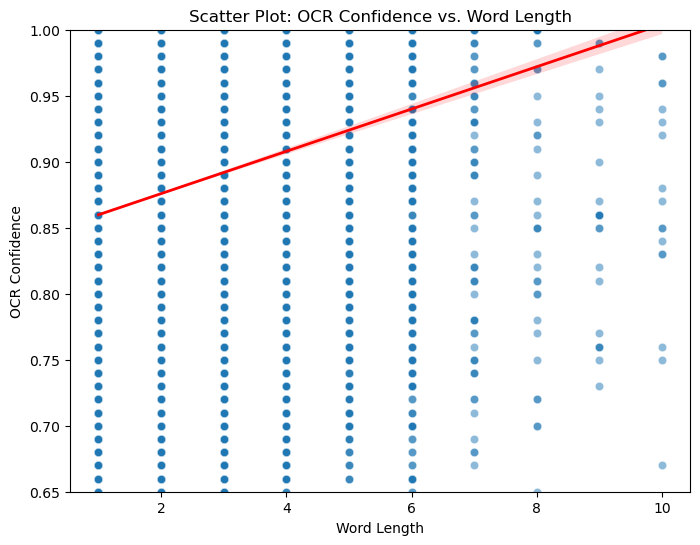

In [3]:
# question 1 plot 1: scatter plot of word length vs. OCR confidence
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_filtered["length"], y=df_filtered["confidence"], alpha=0.5)

# red regression line
sns.regplot(x=df_filtered["length"], y=df_filtered["confidence"], scatter=False, color="red", line_kws={"linewidth": 2})

# y-axis limit between 0.65 and 1 (because 0.65 minimum confidence set during data creation)
plt.ylim(0.65, 1)

plt.xlabel("Word Length")
plt.ylabel("OCR Confidence")
plt.title("Scatter Plot: OCR Confidence vs. Word Length")

plt.show()

In [4]:
# filter words with more than 15 characters
long_words = df[df["word_JAP"].str.len() > 15][["word_JAP", "word_US"]]

print(long_words)

                   word_JAP                                word_US
10461      アニメパキスベシャルブックレット             Anime Paki Special Booklet
12679    ドユアチヨコレトユラボレツョンツャツ  Douya Chocolate Yura Bore Tsyon Paste
28671      チャンビオンコミックスエクストラ                  Champion Comics Extra
29251     テセソビオソユミックスエクスドラン             Tesse Sobio Soy Mix Exdran
29844    シヨンバキスペシャルブツクレツトベヅ         Shionbaki Special Booklet Bezu
31037  レアニメションバキスペシャルブックレット       Reanimation Baki Special Booklet
34091      チャンビオンコミツクスエクストラ                  Champion Comics Extra
34206      チャンビオンコミツクスエクストラ                  Champion Comics Extra
34643     オリジナルチャンピオンマクワッペン             Original Champion McPappen


In [5]:
# jitter strength
jitter_strength = 0.1  # Adjust this value as needed

# create jittered columns
df_filtered["jittered_length"] = df_filtered["length"] + np.random.uniform(-jitter_strength, jitter_strength, len(df_filtered))
df_filtered["jittered_confidence"] = df_filtered["confidence"] + np.random.uniform(-jitter_strength, jitter_strength, len(df_filtered))


In [6]:
# KDE calculation using jittered values
xy = np.vstack([df_filtered['jittered_length'], df_filtered['jittered_confidence']])
kde = gaussian_kde(xy)  
density = kde(xy)  

# normalize density values
norm_density = (density - np.min(density)) / (np.max(density) - np.min(density))

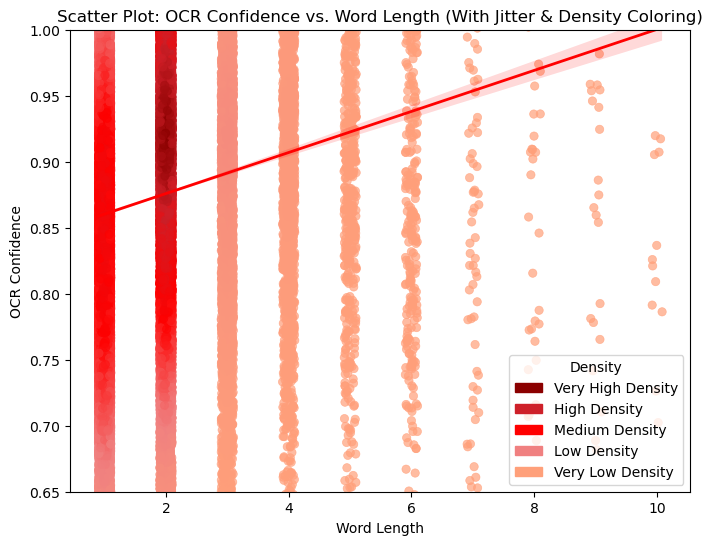

In [7]:
# custom red palette (light red to dark red)
custom_reds = LinearSegmentedColormap.from_list(
    "custom_reds", ["#ffa07a", "#f08080", "#ff0000", "#ce2029", "#8b0000"]
)

# question 1 plot 1: scatter plot with density-based coloring
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["jittered_length"], 
    y=df_filtered["jittered_confidence"], 
    alpha=0.7, 
    hue=norm_density,
    palette=custom_reds,  # Apply custom red gradient
    edgecolor=None
)

# Regression line
sns.regplot(x=df_filtered["jittered_length"], y=df_filtered["jittered_confidence"], scatter=False, color="red", line_kws={"linewidth": 2})

# Set y-axis limit between 0.65 and 1
plt.ylim(0.65, 1)

plt.xlabel("Word Length")
plt.ylabel("OCR Confidence")
plt.title("Scatter Plot: OCR Confidence vs. Word Length (With Jitter & Density Coloring)")

legend_labels = [
    mpatches.Patch(color="#8b0000", label="Very High Density"),
    mpatches.Patch(color="#ce2029", label="High Density"),
    mpatches.Patch(color="#ff0000", label="Medium Density"),
    mpatches.Patch(color="#f08080", label="Low Density"),
    mpatches.Patch(color="#ffa07a", label="Very Low Density"),
]

plt.legend(handles=legend_labels, title="Density", loc="lower right")

plt.show()

C:\Users\andne\AppData\Local\Temp\ipykernel_2776\53058912.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


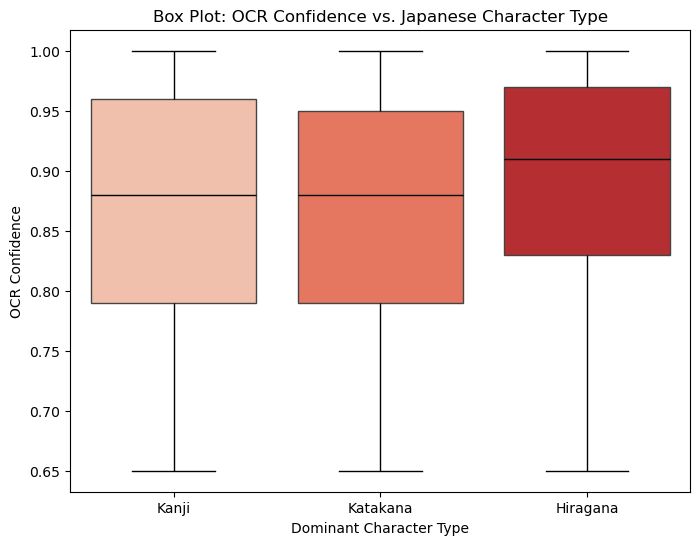

In [8]:
# function to find dominant character type
def classify_character_type(row):
    max_ratio = max(row["hiragana_ratio"], row["katakana_ratio"], row["kanji_ratio"])
    if max_ratio == row["kanji_ratio"]:
        return "Kanji"
    elif max_ratio == row["katakana_ratio"]:
        return "Katakana"
    else:
        return "Hiragana"

# apply classification
df_filtered["char_type"] = df_filtered.apply(classify_character_type, axis=1)

# question 1 plot 2: box plot
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="char_type", 
    y="confidence", 
    data=df_filtered, 
    palette="Reds",
    whiskerprops=dict(color="black"),  # whiskers
    capprops=dict(color="black"),  # caps
    medianprops=dict(color="black")  # median line
)

plt.xlabel("Dominant Character Type")
plt.ylabel("OCR Confidence")
plt.title("Box Plot: OCR Confidence vs. Japanese Character Type")

plt.show()

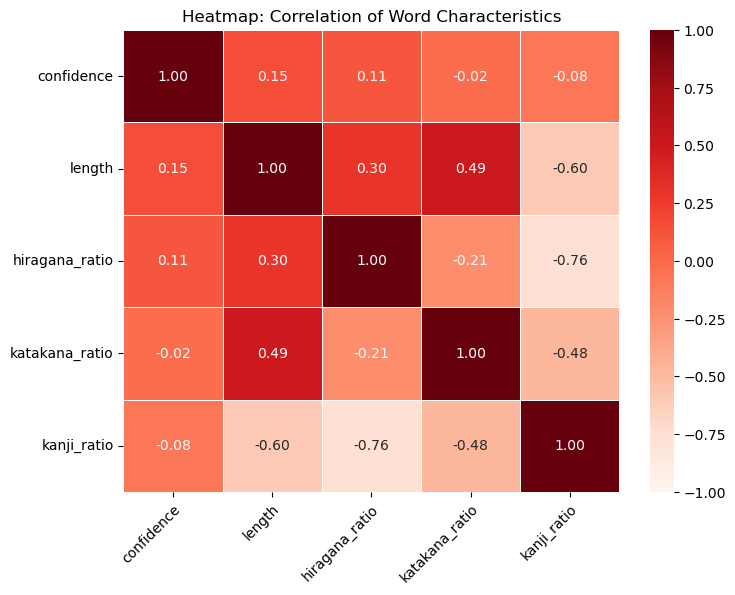

In [9]:
# use only relevant numerical columns
correlation_data = df_filtered[["confidence", "length", "hiragana_ratio", "katakana_ratio", "kanji_ratio"]]

# correlation matrix
corr_matrix = correlation_data.corr()

# question 1 plot 3: heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True,  # show correlation values
    cmap="Reds", 
    fmt=".2f",  # format numbers to 2 decimal places
    linewidths=0.5,  # add lines between cells for clarity
    vmin=-1, vmax=1  # ensure consistent color scaling
)

# tilt x axis names
plt.xticks(rotation=45, ha="right", rotation_mode="anchor", x=0.1)

plt.title("Heatmap: Correlation of Word Characteristics")
plt.show()


Inferences and Explanations of the Visualization for Q1:
1. OCR confidence increases with word length
- It is possible that shorter words suffer from lack of context or character misinterpretation. In addition, longer words usually do not include complex kanji symbols (most words can be written with few logographic kanji characters, but many alphabetic hiragana). OCR confidence performs, in general, better on words that are simpler to read (easy characters with few strokes), resulting in better confidence of their extraction.

2. OCR confidence better on hiragana dominant words
- As stated previously, since hiragana characters are simpler than kanji or katakana characters, OCR might have an easier time recognizing them, resulting in better accuracy. Its also important to take into consideration manga fonts, as these can significantly affect the looks of all characters on a page, further reducing accuracy for complex characters.

3. Heatmap shows slight positive correlation of confidence for the variables of word length and hiragana ratio, while having a slight negative correlation for the variables of katakana ratio and kanji ratio words. These results confirm the results of #1 and #2. Its also interesting to note that katakana ratio words (representing words of foreign origin) are not used often in natural text, and this reduced usage may limit OCR's ability to read katakana properly.

In [10]:
# list of useless words to filter out
stopwords = {
    "the", "a", "an", "and", "or", "but", "if", "so", "because",
    "in", "on", "at", "to", "from", "with", "by", "about", "of",
    "is", "are", "was", "were", "be", "being", "been", "am",
    "have", "has", "had", "do", "does", "did", "can", "could",
    "will", "would", "shall", "should", "must", "may", "might",
    "this", "that", "these", "those", "there", "here", "where",
    "when", "how", "say", "said", "tell", "told", "see", "saw",
    "look", "looked", "come", "go", "went", "take", "took",
    "make", "made", "get", "got", "know", "knew", "think",
    "thought", "want", "wanted", "like", "liked", "need",
    "needed", "use", "used", "find", "found", "give", "gave",
    "work", "works", "working", "try", "tried", "ask", "asked",
    "good", "bad", "better", "best", "worst", "big", "small",
    "little", "huge", "tiny", "old", "new", "young", "great",
    "nice", "mean", "strong", "weak", "happy", "sad",
    "I", "me", "my", "mine", "you", "your", "yours",
    "he", "him", "his", "she", "her", "hers", "it", "its",
    "we", "us", "our", "ours", "they", "them", "their", "theirs",
    "yes", "no", "maybe", "okay", "really", "very", "just", "even", "still", "yet",
    "oh", "uh", "um", "hmm", "ah", "haha", "lol", "hmm", "what",
    "it", "the", "not", "is", "no", "of"
}

C:\Users\andne\AppData\Local\Temp\ipykernel_2776\392230779.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\andne\AppData\Local\Temp\ipykernel_2776\392230779.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\andne\AppData\Local\Temp\ipykernel_2776\392230779.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


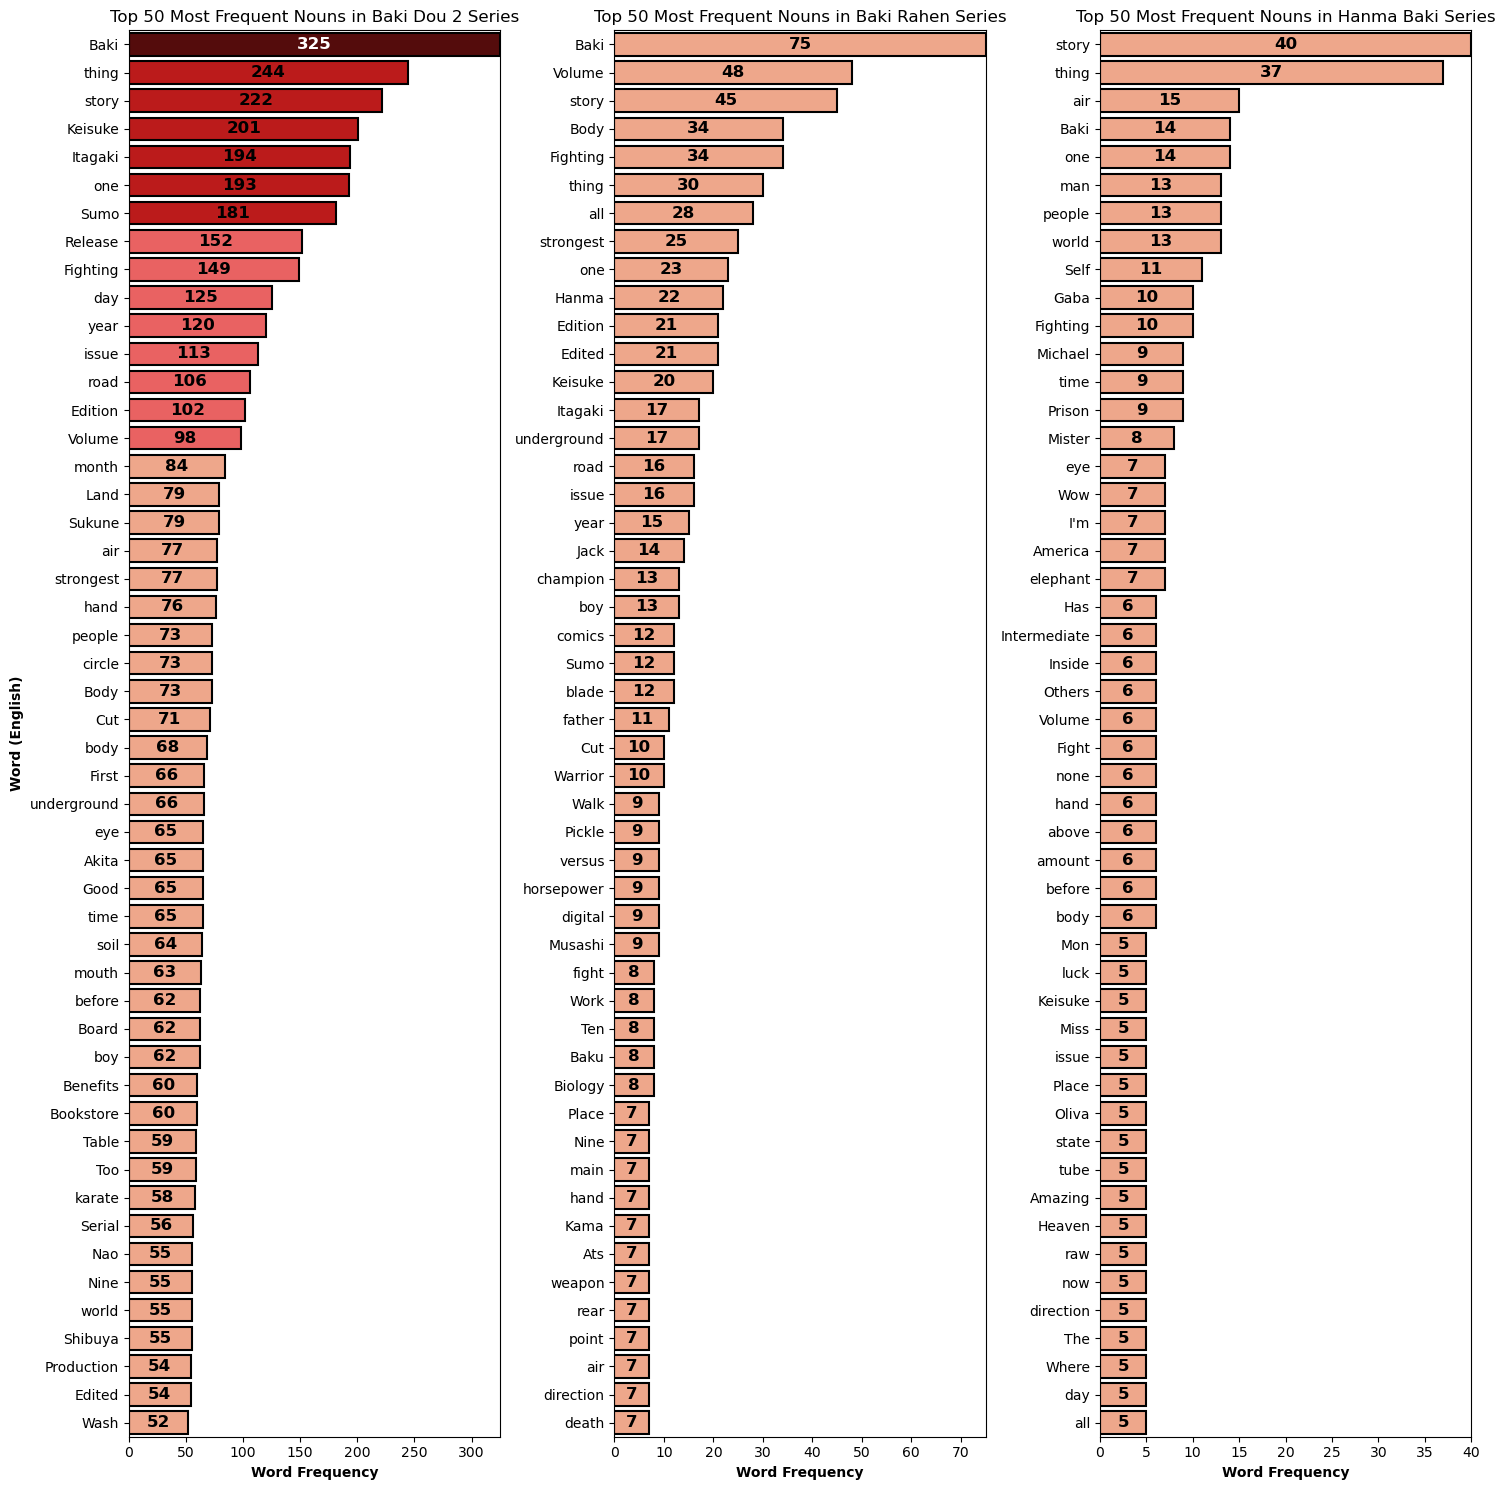

In [11]:
# custom red color range 
custom_reds = ["#ffa07a", "#ff4c4c", "#d60000", "#a00000", "#600000"]

# filter for nouns only
df_word_freq1 = df[df["word_POS"] == "noun"]

# remove words with spaces or numbers
df_word_freq1 = df_word_freq1[~df_word_freq1["word_US"].str.contains(r"\s|\d", na=False, regex=True)]

# filter out not significant words
df_word_freq1 = df_word_freq1[~df_word_freq1["word_US"].isin(stopwords)]

# total occurrences of words per series
word_counts = df_word_freq1.groupby(["img_series", "word_US"])["word_US"].count().reset_index(name="word_count")
# sort by frequency for each series (top 50)
top_n = 50
word_counts_top = word_counts.sort_values(by="word_count", ascending=False).groupby("img_series").head(top_n)

# get global min and max
global_min = word_counts_top["word_count"].min()
global_max = word_counts_top["word_count"].max()

# function to map word count to the custom red color range
def map_to_custom_reds(value, vmin, vmax):
    norm_value = (value - vmin) / (vmax - vmin)
    color_index = int(norm_value * (len(custom_reds) - 1))
    return custom_reds[color_index]

# question 2 plot 1: bar graphs
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

# loop over each series and create individual bar plots
for idx, series in enumerate(word_counts_top['img_series'].unique()):
    ax = axes[idx]
    data = word_counts_top[word_counts_top["img_series"] == series]

    max_value = data["word_count"].max()

    bar_colors = [map_to_custom_reds(value, global_min, global_max) for value in data["word_count"]]

    bars = sns.barplot(
        x="word_count", 
        y="word_US", 
        data=data, 
        ax=ax,
        palette=bar_colors
    )

    # black edge color of bars
    for bar in bars.patches:
        bar.set_edgecolor("black")
        bar.set_linewidth(1.5)

    # word frquency inside each bar
    for i, value in enumerate(data["word_count"]):

        text_color = "white" if series == "Baki Dou 2" and value == max_value else "black"
        ax.text(value / 2, i, str(value), ha='center', va='center', fontsize=12, color=text_color, fontweight="bold")

    # titling
    adjusted_series = series.replace("Hanma_Baki", "Hanma Baki")
    title = f"Top {top_n} Most Frequent Nouns in {adjusted_series} Series"
    ax.set_title(title, fontweight='normal')

    # y-axis
    if idx == 0:
        ax.set_ylabel("Word (English)", fontweight='bold')
    if idx == 1:
        ax.set_ylabel("Word (English)", fontweight='bold')
    if idx == 2:
        ax.set_ylabel("Word (English)", fontweight='bold')

    # x-axis
    if idx == 0:
        ax.set_xlabel("Word Frequency", fontweight='bold')
    if idx == 1:
        ax.set_xlabel("Word Frequency", fontweight='bold')
    if idx == 2:
        ax.set_xlabel("Word Frequency", fontweight='bold')

    # remove y-axis labels
    if idx == 1:
        ax.set_ylabel('')
    if idx == 2:
        ax.set_ylabel('')

    ax.set_xlim(0, data["word_count"].max())

plt.tight_layout()
plt.show()


Below code and graph not includes in final blog post.

C:\Users\andne\AppData\Local\Temp\ipykernel_2776\533608988.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\andne\AppData\Local\Temp\ipykernel_2776\533608988.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\andne\AppData\Local\Temp\ipykernel_2776\533608988.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\andne\AppData\Local\Temp\ipykernel_2776\533608988.py:93: UserWarning: Glyph 12363 (\N{HIRAGANA LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\andne\A

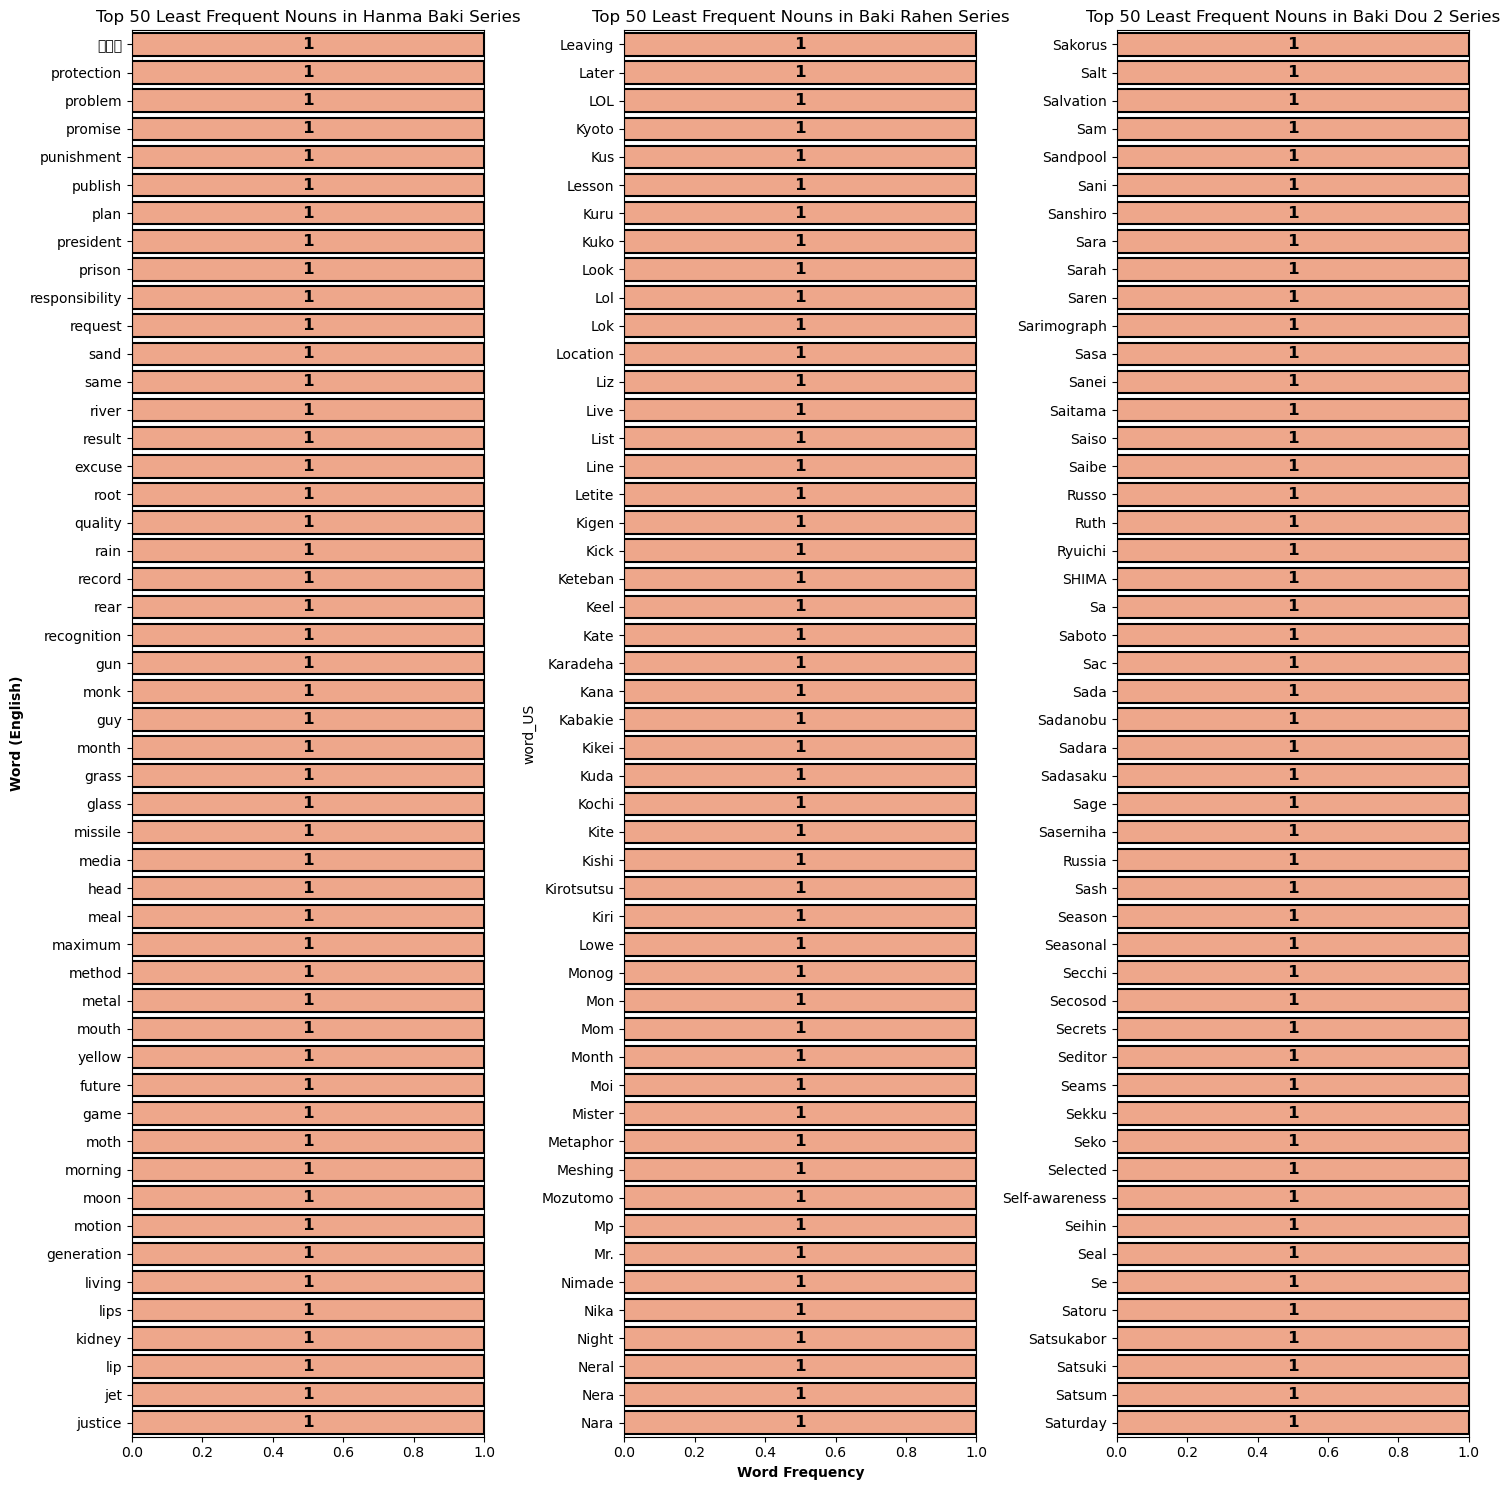

In [12]:
# custom red color range 
custom_reds = ["#ffa07a", "#ff4c4c", "#d60000", "#a00000", "#600000"]

# filter for nouns only & drop null values
df_word_freq = df[df["word_POS"] == "noun"].dropna()

# remove words with spaces or numbers
df_word_freq = df_word_freq[~df_word_freq["word_US"].str.contains(r"\s|\d", na=False, regex=True)]

# filter out not significant words
df_word_freq = df_word_freq[~df_word_freq["word_US"].isin(stopwords)]

# total occurrences of words per series
word_counts = df_word_freq.groupby(["img_series", "word_US"])["word_US"].count().reset_index(name="word_count")

# remove any NaN values from word counts
word_counts = word_counts.dropna()

# sort by frequency for each series and get the bottom 50 (least frequent words)
top_n = 50
word_counts_bottom = word_counts.sort_values(by="word_count", ascending=True).groupby("img_series").head(top_n)

# get global min and max
global_min = word_counts_bottom["word_count"].min()
global_max = word_counts_bottom["word_count"].max()

# prevent division by zero
if global_max == global_min:
    global_max += 1

# function to map word count to the custom red color range
def map_to_custom_reds(value, vmin, vmax):
    if np.isnan(value):
        return custom_reds[0]
    norm_value = (value - vmin) / (vmax - vmin) if vmax > vmin else 0
    color_index = int(norm_value * (len(custom_reds) - 1))
    return custom_reds[color_index]

# question 2 plot 1: bar graphs
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

# loop over each series and create individual bar plots
for idx, series in enumerate(word_counts_bottom['img_series'].unique()):
    ax = axes[idx]
    data = word_counts_bottom[word_counts_bottom["img_series"] == series]

    max_value = data["word_count"].max()

    bar_colors = [map_to_custom_reds(value, global_min, global_max) for value in data["word_count"]]

    bars = sns.barplot(
        x="word_count", 
        y="word_US", 
        data=data, 
        ax=ax,
        palette=bar_colors
    )

    # black edge color of bars
    for bar in bars.patches:
        bar.set_edgecolor("black")
        bar.set_linewidth(1.5)

    # word frequency inside each bar
    for i, value in enumerate(data["word_count"]):
        ax.text(value / 2, i, str(value), ha='center', va='center', fontsize=12, color=text_color, fontweight="bold")

    # titling
    adjusted_series = series.replace("Hanma_Baki", "Hanma Baki")
    title = f"Top {top_n} Least Frequent Nouns in {adjusted_series} Series"
    ax.set_title(title, fontweight='normal')

    # y-axis
    if idx == 0:
        ax.set_ylabel("Word (English)", fontweight='bold')

    # x-axis
    if idx == 1:
        ax.set_xlabel("Word Frequency", fontweight='bold')

    # remove x-axis labels
    if idx == 0:
        ax.set_xlabel('')
    if idx == 2:
        ax.set_xlabel('')

    # remove y-axis labels
    if idx == 2:
        ax.set_ylabel('')

    ax.set_xlim(0, data["word_count"].max())

plt.tight_layout()
plt.show()


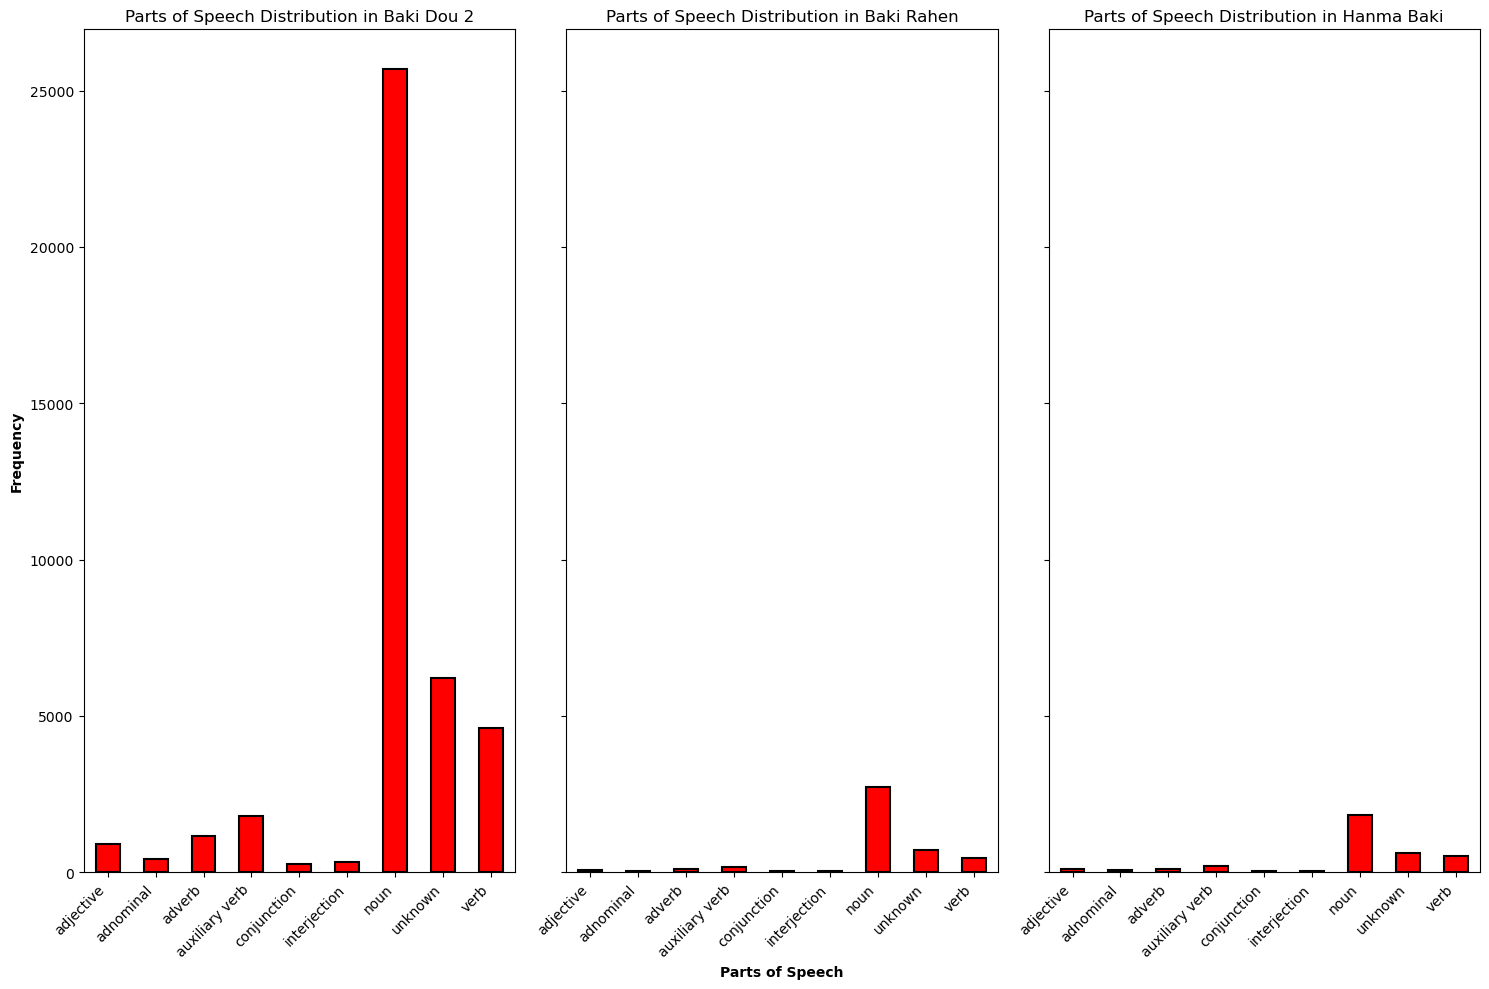

In [13]:
# filter dataset & remove nulls
df_filtered3 = df.dropna(subset=["word_POS", "img_series"])

# count occurrences of each POS per series
pos_counts = df_filtered3.groupby(["img_series", "word_POS"])["word_POS"].count().reset_index(name="count")

# pivot table for stacked bar format
pos_pivot = pos_counts.pivot(index="img_series", columns="word_POS", values="count").fillna(0)

# sort POS categories for consistency
pos_pivot = pos_pivot[sorted(pos_pivot.columns)]

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=True)

# question 2 plot 2: bar graphs
for idx, series in enumerate(pos_pivot.index):
    ax = axes[idx]

    data = pos_pivot.loc[series]

    # solid red bars
    data.plot(kind="bar", stacked=True, color="red", edgecolor="black", linewidth=1.5, ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    # title for each subplot
    adjusted_series = series.replace("Hanma_Baki", "Hanma Baki")
    ax.set_title(f"Parts of Speech Distribution in {adjusted_series}", fontweight="normal")

    # x-axis label
    if idx == 1:
        ax.set_xlabel("Parts of Speech", fontweight="bold")

    # y-axis label for the first graph only
    if idx == 0:
        ax.set_ylabel("Frequency", fontweight="bold")

    # remove x-axis labels
    if idx == 0:
        ax.set_xlabel('')
    if idx == 2:
        ax.set_xlabel('')

plt.tight_layout()
plt.show()

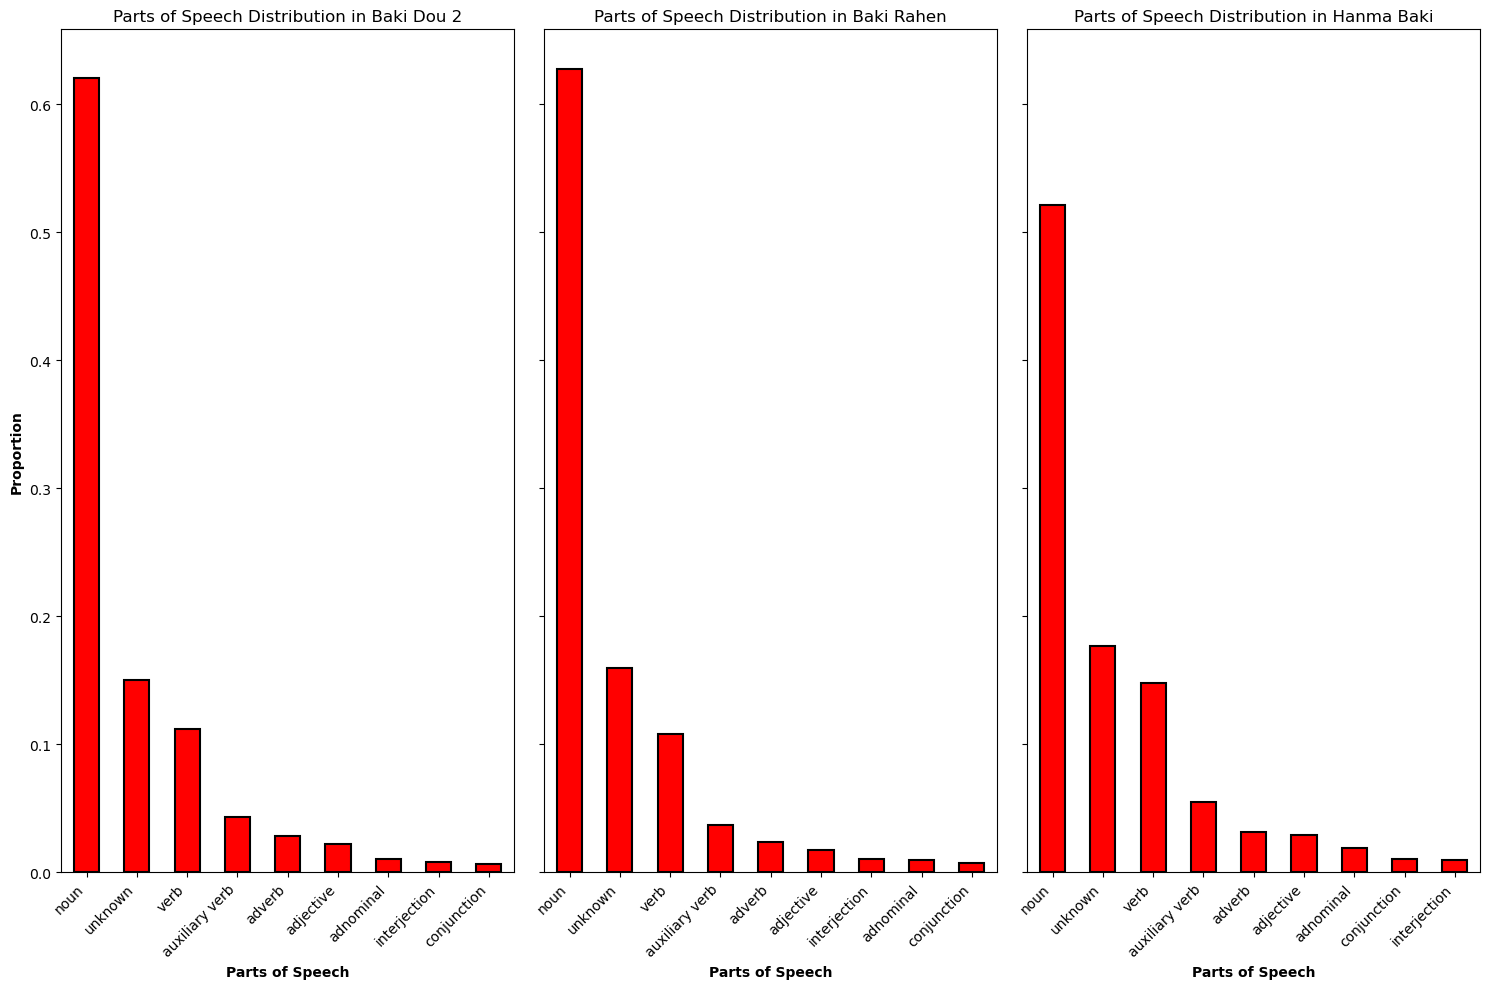

In [14]:
# filter dataset & remove nulls
df_filtered4 = df.dropna(subset=["word_POS", "img_series"])

# count occurrences of each POS per series
pos_counts = df_filtered4.groupby(["img_series", "word_POS"])["word_POS"].count().reset_index(name="count")

# pivot table for stacked bar format
pos_pivot = pos_counts.pivot(index="img_series", columns="word_POS", values="count").fillna(0)

# calculate total words in each series
total_words_per_series = pos_pivot.sum(axis=1)

# normalize each part of speech count by total words in the series
pos_pivot_normalized = pos_pivot.div(total_words_per_series, axis=0)

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=True)

# question 2 plot 2: bar graphs
for idx, series in enumerate(pos_pivot_normalized.index):
    ax = axes[idx]

    data = pos_pivot_normalized.loc[series].sort_values(ascending=False)  # sort by proportion

    data.plot(kind="bar", stacked=True, color="red", edgecolor="black", linewidth=1.5, ax=ax)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

    adjusted_series = series.replace("Hanma_Baki", "Hanma Baki")
    ax.set_title(f"Parts of Speech Distribution in {adjusted_series}", fontweight="normal")

    ax.set_xlabel("Parts of Speech", fontweight="bold")
    ax.set_ylabel("Proportion", fontweight="bold")

plt.tight_layout()
plt.show()

C:\Users\andne\AppData\Local\Temp\ipykernel_2776\112222898.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words.values, y=words.index, ax=ax, palette=colors, edgecolor="black")
C:\Users\andne\AppData\Local\Temp\ipykernel_2776\112222898.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words.values, y=words.index, ax=ax, palette=colors, edgecolor="black")
C:\Users\andne\AppData\Local\Temp\ipykernel_2776\112222898.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=words.values, y=words.index, ax=ax, palette=colors, edgecolor="

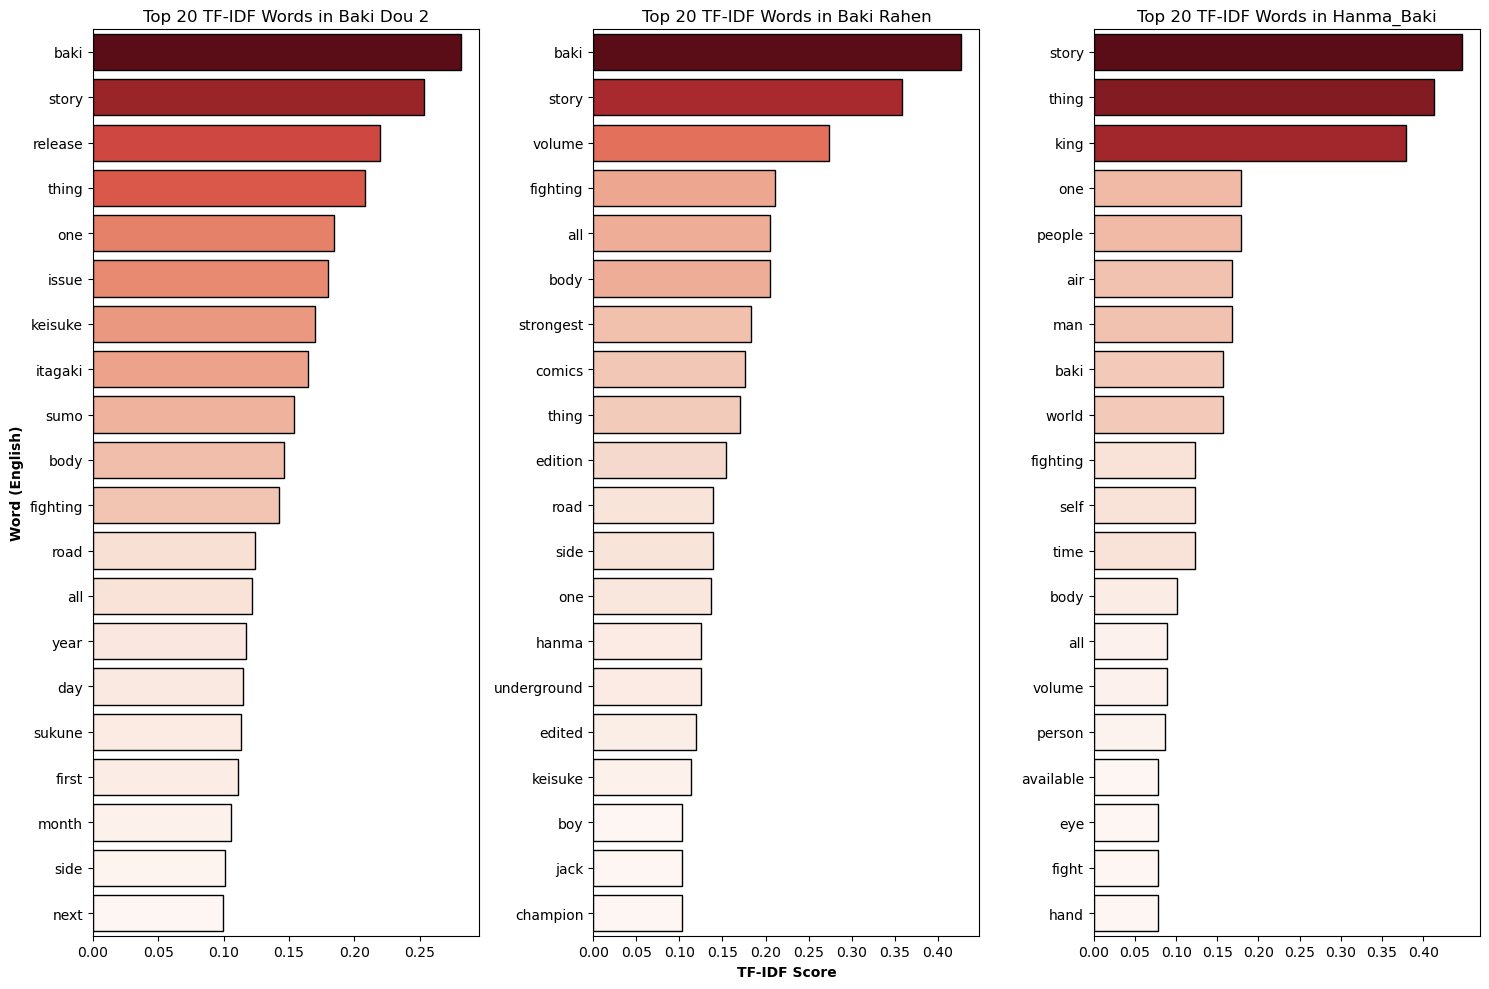

In [15]:
# convert stopwords set to list
stopwords_list = list(stopwords)

# filter dataset & remove nulls
df_filtered_tfidf = df.dropna(subset=["word_US", "img_series"])

# only nouns
df_filtered_tfidf = df_filtered_tfidf[df_filtered_tfidf["word_POS"] == "noun"]

# remove stopwords from "word_US" column
df_filtered_tfidf = df_filtered_tfidf[~df_filtered_tfidf["word_US"].isin(stopwords_list)]

# put all words into a single document per series
series_documents = df_filtered_tfidf.groupby("img_series")["word_US"].apply(lambda x: ' '.join(x)).reset_index()

# TF-IDF vectorizer setup with custom stopwords
vectorizer = TfidfVectorizer(max_features=300, stop_words=stopwords_list)
tfidf_matrix = vectorizer.fit_transform(series_documents["word_US"])

# matrix to dataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=series_documents["img_series"], columns=vectorizer.get_feature_names_out())

# top 20 highest TF-IDF words per series
top_n = 20
top_words_per_series = {}

for series in tfidf_df.index:
    top_words = tfidf_df.loc[series].nlargest(top_n)
    top_words_per_series[series] = top_words

# colors
cmap = plt.cm.Reds
norm = mcolors.Normalize(vmin=0, vmax=1)  # Normalize between 0 and 1 for the color map

# question 2 plot 3: TF-IDF
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for idx, (series, words) in enumerate(top_words_per_series.items()):
    ax = axes[idx]
    
    # normalize TF-IDF values for each word to create color gradient
    normalized_values = (words.values - words.values.min()) / (words.values.max() - words.values.min())
    colors = [cmap(norm(val)) for val in normalized_values]
    
    sns.barplot(x=words.values, y=words.index, ax=ax, palette=colors, edgecolor="black")
    ax.set_title(f"Top {top_n} TF-IDF Words in {series}")
    ax.set_xlabel("TF-IDF Score")
    ax.set_ylabel("Word (English)")

    # x-axis label
    if idx == 1:
        ax.set_xlabel("TF-IDF Score", fontweight="bold")

    # y-axis label
    if idx == 0:
        ax.set_ylabel("Word (English)", fontweight="bold")

    # remove x-axis
    if idx == 0:
        ax.set_xlabel('')
    if idx == 2:
        ax.set_xlabel('')

    # remove y-axis labels
    if idx == 1:
        ax.set_ylabel('')
    if idx == 2:
        ax.set_ylabel('')

    # set x-axis ticks to intervals of 0.05
    ax.set_xticks([i * 0.05 for i in range(int(words.values.max() // 0.05) + 1)])

plt.tight_layout()
plt.show()

Inferences and Explanations of the Visualization for Q2:
1. Top 50 Frequent Nouns
- The main types of words that appear in these three visualizations between the series are words lik Baki, Hanma, Itagaki, and combat-related terms. This highlights the central themes in Baki: fighting, strength, and of course the journey of the main protagonist Hanma Baki. This is becasue the character learns and thrives in combat and his experiences help him to develop immense character. 
- Names are interesting because they point to how character-centric Baki as a manga is. It means that without Baki as a character, there would be no story. In addition, words relating to fighting styles reinforce the second focus on the manga which are martial arts and battle.
- legacy, family, personal growth (from use of names)

2. Parts of Speech Distribution
- In the POS normalized graphs, the usage of parts of speech across the three series are almost identical, showing a consistency in writing. It's interesting to see that from 2005 (start of Hanma Baki series) to present 2025 (current time of Baki Rahen series in progress) Keisuke Itagaki's writing style hasn't changed at all, showing that age did not change the author's desire for making this manga. 
- Considering this, it's improtant to note that in Hanma Baki, slightly fewer nouns and more verbs are used.

3. TF-IDF 
- In addition to the first bar graph visualizations, the TF-IDF values also highlight combat words and words relating to martial prowess as central themes across all three series. It means that even if the story evolves, the core elements remain largely unchanged. 
- It's interesting to note that location words do change across series, shwoing the different settings of each manga arc. This means that as the story evolves, so does the environment, making this another key factor in the overall story.



Below code and graph not includes in final blog post.

In [16]:
# stopwords into list
stopwords_list = list(stopwords)

# filter data
df_filtered_tfidf = df.dropna(subset=["word_US", "img_series"])
df_filtered_tfidf = df_filtered_tfidf[df_filtered_tfidf["word_POS"] == "noun"]
df_filtered_tfidf = df_filtered_tfidf[~df_filtered_tfidf["word_US"].isin(stopwords_list)]

# create documents per series
series_documents = df_filtered_tfidf.groupby("img_series")["word_US"].apply(lambda x: ' '.join(x)).reset_index()

# more TF-IDF (used by NMF)
vectorizer = TfidfVectorizer(
    max_features=200,         # fewer features = less noise
    min_df=2,                 # only keep words that appear in at least 2 docs
    stop_words=stopwords_list
)
tfidf_matrix = vectorizer.fit_transform(series_documents["word_US"])

# NMF code
n_topics = 3
nmf_model = NMF(n_components=n_topics, random_state=42, max_iter=600)
nmf_features = nmf_model.fit_transform(tfidf_matrix)

# top words per topic
n_top_words = 30
feature_names = vectorizer.get_feature_names_out()

topic_words = {}
for topic_idx, topic in enumerate(nmf_model.components_):
    top_indices = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_indices]
    topic_words[f"Topic {topic_idx}"] = top_words

for topic, words in topic_words.items():
    print(f"{topic}: {', '.join(words)}\n")

Topic 0: baki, story, volume, fighting, all, body, strongest, comics, thing, edition, side, road, one, hanma, underground, edited, keisuke, boy, champion, itagaki, issue, year, blade, father, dream, book, digital, sumo, death, pillow

Topic 1: story, thing, king, people, one, air, man, world, baki, self, time, fighting, body, all, volume, inside, wow, newly, available, fight, eye, place, hand, oliva, partner, others, intermediate, above, given, name

Topic 2: baki, issue, story, keisuke, one, itagaki, thing, sumo, day, month, first, body, road, year, next, fighting, land, circle, time, side, all, table, soil, too, hand, comics, karate, man, shibuya, nao



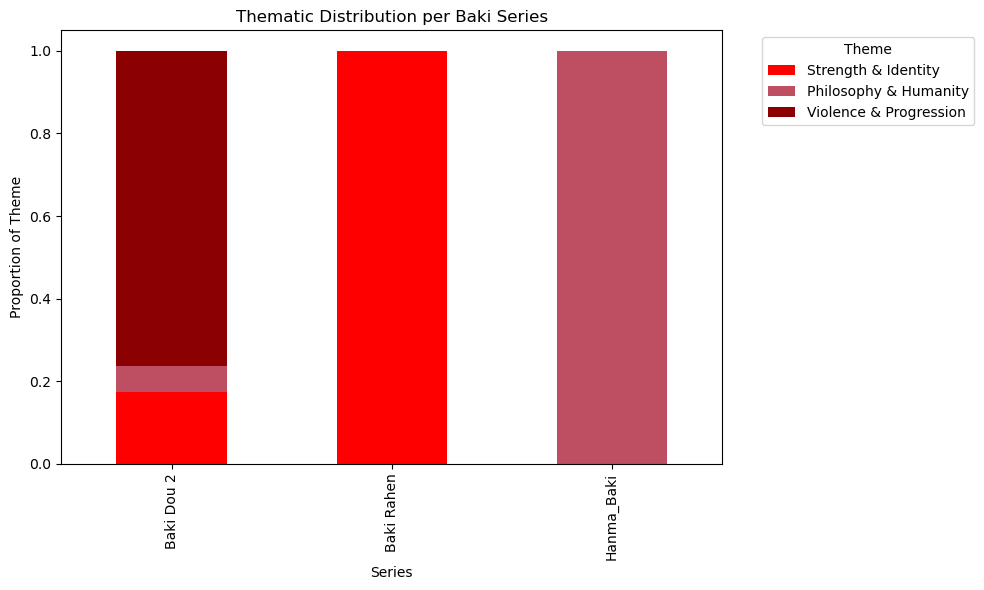

In [17]:
# topic labels
topic_labels = {
    0: "Strength & Identity",
    1: "Philosophy & Humanity",
    2: "Violence & Progression"
}

# NMF output into a df 
nmf_df = pd.DataFrame(nmf_features, index=series_documents["img_series"])
nmf_df.columns = [topic_labels[i] for i in nmf_df.columns]

# normalize
nmf_df_norm = nmf_df.div(nmf_df.sum(axis=1), axis=0)

# custom colors
custom_colors = {
    "Strength & Identity": "#ff0000",
    "Philosophy & Humanity": "#be4f62",
    "Violence & Progression": "#8b0000"
}
color_list = [custom_colors[col] for col in nmf_df_norm.columns]

# question 3 plot 1: NMF - Non-Negative Matrix Factorization
nmf_df_norm.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=color_list
)

plt.title("Thematic Distribution per Baki Series")
plt.ylabel("Proportion of Theme")
plt.xlabel("Series")
plt.legend(title="Theme", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Inferences and Explanations of the Visualization for Q3:
1. Theme Distribution Across the Baki Series
- Baki Dou 2 seems to cover all three themes present in the manga series vocabulary, with violence & progression taking up a majority. 
- Baki Rahen is entierly comprised of the theme of Strength & Identity and Hanma Baki series is entirely composed of Philosophy & Humanity. Even though these results for the non-defferentiating two series is strange, it makes sense due to the story presented in each, as well as the fact that these amount of words are significantly smaller compared to the amount of Baki Dou 2 words.